In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/My Drive/MVA/Medical Imagery/3md3070-dlmi.zip" -d "/data"

In [ ]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchsummary import summary
from sklearn.metrics import f1_score, classification_report
import torch.nn.functional as F

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


# Definitition of datasets

In [ ]:
class LymphocytosisDataset(Dataset):
    # nb_img_fill represents the a common maximum for
    nb_img_fill = 200

    def __init__(
        self,
        annotation_csv: str = "/data/clinical_annotation.csv",
        root_dir: str = "/data",
        train: bool = True,
        valid: bool = False,  # If we want the validation set. train must be set at True to get valiation set
        train_split: float = 0.8,  # percentage we want in train (as opposed to valdation)
        transform: callable = transforms.ToTensor(),
        fill_img_list: bool = False,
        split_label: bool = False,
        convert_age: bool = True,
        convert_gender: bool = True,
    ) -> None:
        """
        Loads Lymphocytosis data

        Parameters
        ----------
        annotation_csv : str
            Path to the csv file that contains annotation for every patient
        root_dir : str
            Directory with all the images
        train : bool
            Wether to use training images or not
        transform : callable, optional
            Optional transform to be applied on sample images, by default None
        """
        ## Get the clinical annotation
        self.annotation_frame = pd.read_csv(annotation_csv, index_col=0)
        ## Identify training, validation, and testing ids
        self.train_ids = list(
            self.annotation_frame["ID"][self.annotation_frame["LABEL"] != -1]
        )

        self.valid_ids = self.train_ids[int(len(self.train_ids) * train_split) :]
        self.train_ids = self.train_ids[: int(len(self.train_ids) * train_split)]

        self.test_ids = list(
            self.annotation_frame["ID"][self.annotation_frame["LABEL"] == -1]
        )
        ## Reindex the annotation to the "ID" column
        self.annotation_frame = self.annotation_frame.set_index("ID")
        ## Handle "DOB" column
        DOB = self.annotation_frame["DOB"].copy()
        line_with_slash = DOB.str.contains("/")
        DOB[line_with_slash] = pd.to_datetime(DOB[line_with_slash], format="%m/%d/%Y")
        DOB[~line_with_slash] = pd.to_datetime(DOB[~line_with_slash], format="%d-%m-%Y")
        self.annotation_frame["DOB"] = pd.to_datetime(DOB)

        ## Define instance attributes
        self.root_dir = root_dir
        self.train = train
        self.valid = valid
        self.transform = transform
        self.fill_img_list = fill_img_list
        self.split_label = split_label
        self.convert_age = convert_age

    def __len__(self) -> int:
        if self.train:
            if self.valid:
                return len(self.valid_ids)
            else:
                return len(self.train_ids)
        else:
            return len(self.test_ids)

    def __getitem__(self, index: int) -> tuple:
        if self.train:
            if self.valid:
                id = self.valid_ids[index]
            else:
                id = self.train_ids[index]
        else:
            id = self.test_ids[index]
        annotation = self.annotation_frame.loc[id]
        if self.convert_age:
            annotation["AGE"] = (
                pd.to_datetime("01-01-2021") - annotation["DOB"]
            ).days / 365.25
            annotation = annotation.drop("DOB")
        if self.convert_age:
            annotation["GENDER"] = 1 if annotation["GENDER"] == "M" else 0
        annotation = annotation.to_dict()
        img_dir = f"{self.root_dir}/{'train' if self.train else 'test'}set/{id}/"
        img_list = [
            Image.open(os.path.join(img_dir, img_name))
            for img_name in os.listdir(img_dir)
        ]
        if self.fill_img_list:
            missing = self.nb_img_fill - len(img_list)
            filling_indices = np.random.randint(len(img_list), size=missing)
            for i in filling_indices:
                img_list.append(img_list[i])
        if self.transform is not None:
            img_list = [self.transform(img) for img in img_list]
            img_list = torch.stack(img_list)
        if self.split_label:
            # label = [0, 0]
            # label[annotation["LABEL"]] = 1
            label = [annotation["LABEL"]]
            annotation.pop("LABEL")

            return annotation, img_list, label
        return annotation, img_list


class LymphocytosisImageDataset(Dataset):

    def __init__(
        self,
        annotation_csv: str = "/data/clinical_annotation.csv",
        root_dir: str = "/data",
        train: bool = True,
        valid: bool = False,
        balance: str = "oversample",
        transform: callable = transforms.ToTensor(),
    ) -> None:
        """
        Loads Lymphocytosis images one by one

        Parameters
        ----------
        annotation_csv : str
            Path to the csv file that contains annotation for every patient
        root_dir : str
            Directory with all the images
        train : bool
            Wether to use training images or not
        transform : callable, optional
            Optional transform to be applied on sample images, by default None
        """
        ## Define instance attributes
        self.root_dir = root_dir
        self.train = train
        self.valid = valid
        self.transform = transform

        ## Get the clinical annotation
        self.annotation_frame = pd.read_csv(annotation_csv, index_col=0)
        ## Identify training, and testing ids
        if train:
            self.ids = list(
                self.annotation_frame["ID"][self.annotation_frame["LABEL"] != -1]
            )
            if valid:
                self.ids = self.ids[int(0.8*len(self.ids)):]
            else:
                self.ids = self.ids[:int(0.8*len(self.ids))]
        else:
            self.ids = list(
                self.annotation_frame["ID"][self.annotation_frame["LABEL"] == -1]
            )
        
        ## Reindex the annotation to the "ID" column
        self.annotation_frame = self.annotation_frame.set_index("ID")

        ## Retrieving the path of images for each id
        path_dict = {
            "id": [],
            "path": [],
            "label": [],
        }
        for id in self.ids:
            img_dir = f"{self.root_dir}/{'train' if self.train else 'test'}set/{id}/"
            img_path_list = os.listdir(img_dir)
            path_dict["id"].extend([id]*len(img_path_list))
            path_dict["path"].extend(img_path_list)
            path_dict["label"].extend([self.annotation_frame.loc[id]["LABEL"]]*len(img_path_list))
        
        self.path_df = pd.DataFrame(path_dict)
        if balance == "oversample":
            df_class_0 = self.path_df[self.path_df['label'] == 0]
            df_class_1 = self.path_df[self.path_df['label'] == 1]
            if len(df_class_0) > len(df_class_1):
                df_class_0, df_class_1 = df_class_1, df_class_0
            df_class_0_over = df_class_0.sample(len(df_class_1), replace=True)
            self.path_df = pd.concat([df_class_0_over, df_class_1], axis=0)

    def __len__(self) -> int:
        return len(self.path_df)

    def __getitem__(self, index: int) -> tuple:
        item = self.path_df.iloc[index]
        id, label, path = item["id"], item["label"], item["path"]
        img_path = f"{self.root_dir}/{'train' if self.train else 'test'}set/{id}/{path}"
        img = Image.open(img_path)
        if self.transform is not None:
            img = self.transform(img)

        return img, label

In [ ]:
transform_train = transforms.Compose([
    transforms.CenterCrop(128),
    transforms.Resize(32),
    transforms.ToTensor()
])
img_train_dataset = LymphocytosisImageDataset(train=True, valid=False, balance="oversample", transform=transform_train)
img_val_dataset = LymphocytosisImageDataset(train=True, valid=True, balance="oversample", transform=transform_train)
img_test_dataset = LymphocytosisImageDataset(train=False, valid=False, balance="no", transform=transform_train)

lymphocytosis_train_dataset = LymphocytosisDataset(train=True, transform=transform_train, split_label=True)
lymphocytosis_val_dataset = LymphocytosisDataset(train=True, valid=True, transform=transform_train, split_label=True)
lymphocytosis_test_dataset = LymphocytosisDataset(train=False, valid=False, transform=transform_train, split_label=True)

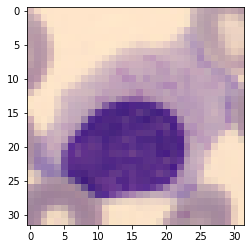

In [ ]:
plt.imshow(img_train_dataset[30][0].permute(1,2,0))

# Autoencoder for Lymphocytosis images

In the following cells, I define an autoencoder in order to have a model that understands the blood smears. However, it looks like it tends to forget more about about the lymphocyte and therefore, it can be assumed that it will not help that much for lymphocytosis prediction.

In [ ]:
def get_activation(activation_type):
    # activation_type = activation_type.lower()
    if hasattr(nn, activation_type):
      return getattr(nn, activation_type)()
    else:
      return nn.ReLU()

class ConvBatchNorm(nn.Module):
    """(convolution => [BN] => ReLU)"""  
    def __init__(self, in_channels, out_channels, activation='ReLU'):
        super(ConvBatchNorm, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = get_activation(activation)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return self.activation(x)

def _make_nConv(in_channels, out_channels, nb_Conv, activation='ReLU'):
    layers = []
    layers.append(ConvBatchNorm(in_channels, out_channels, activation))
    for _ in range(nb_Conv-1):
        layers.append(ConvBatchNorm(out_channels, out_channels, activation))
    return nn.Sequential(*layers)

def _make_nDeConv(in_channels, out_channels, nb_Conv, activation='ReLU'):
    layers = []
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, padding=1, stride=2, output_padding=1))
    for _ in range(nb_Conv):
        layers.append(ConvBatchNorm(out_channels, out_channels, activation))
    return nn.Sequential(*layers)

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, nb_Conv=1, activation="ReLU"):
        super(DownBlock, self).__init__()
        self.conv_bn = _make_nConv(in_channels, out_channels, nb_Conv, activation)
        self.down = nn.MaxPool2d(2)
        # self.down = nn.Conv2d(out_channels, out_channels, kernel_size=2, stride=2)
    
    def forward(self, x):
        x = self.conv_bn(x)
        x = self.down(x)
        # print(x.shape)
        return x

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, nb_Conv, activation="ReLU"):
        super(UpBlock, self).__init__()
        # self.deconv_bn = _make_nDeConv(in_channels, out_channels, nb_Conv)
        self.up = nn.Upsample(scale_factor=2)
        self.conv_bn = _make_nConv(in_channels, out_channels, nb_Conv, activation)
    
    def forward(self, x):
        x = self.up(x)
        x = self.conv_bn(x)
        return x

class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        # Input (3, 224, 224)
        self.encoder = nn.Sequential(
            DownBlock(3, 64, 2), # Output (64, 112, 112)
            DownBlock(64, 32, 2), # Output (32, 56, 56)
            # DownBlock(32, 16, 2), # Output (16, 28, 28)
            # DownBlock(16, 8, 2), # Output (8, 14, 14)
        )
        self.decoder = nn.Sequential(
            # UpBlock(8, 16, 2), # Output (16, 28, 28)
            # UpBlock(16, 32, 2), # Output (32, 56, 56)
            UpBlock(32, 64, 2), # Output (64, 112, 112)
            UpBlock(64, 3, 1), # Output (3, 224, 224)
            nn.Conv2d(3, 3, kernel_size=3, padding=1),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
def train_autoencoder(model, optimizer, criterion, dataloader):
    total_loss = 0
    pbar = tqdm(dataloader)
    for i, (imgs, labels) in enumerate(pbar):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        reconstruction = model(imgs)
        loss = criterion(imgs, reconstruction)
        loss.backward()
        optimizer.step()
        total_loss += loss
        pbar.set_postfix({"loss": total_loss/(i+1)})


In [ ]:
img_autoencoder_loader = DataLoader(img_train_dataset, batch_size=50)

In [ ]:
model = ConvAutoEncoder().to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
num_epochs = 3
for epoch in range(num_epochs):
    train_autoencoder(model, optimizer, criterion, img_autoencoder_loader)

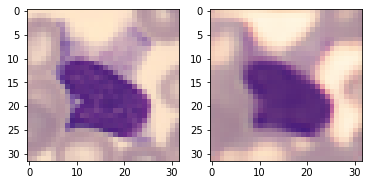

In [ ]:
img = img_train_dataset[20][0].to(device)
generated = model(img.unsqueeze(0))[0]
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(img.cpu().permute(1,2,0))
ax2.imshow(generated.cpu().detach().permute(1,2,0))

(array([ 1598.,   486.,   796.,  1363.,  4622., 15439., 29500., 39740.,
        29918., 27066.]),
 array([0.04091498, 0.13611245, 0.2313099 , 0.3265074 , 0.42170486,
        0.5169023 , 0.61209977, 0.70729727, 0.8024947 , 0.8976922 ,
        0.99288964], dtype=float32),
 <a list of 10 Patch objects>)

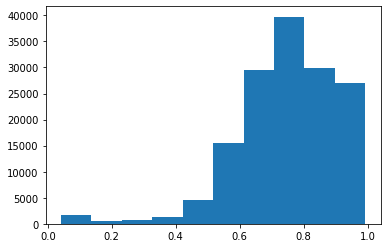

In [ ]:
plt.hist(generated.flatten().cpu().detach())

# Prediction image by image
Another approach is to predict image by image with a simple model.
We can use transfer learning for this task.

In [ ]:
import torchvision.models as models

In [ ]:
def train_classification(model, optimizer, criterion, dataloader):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    batch_pbar = tqdm(dataloader)
    for batch_idx, (imgs, labels) in enumerate(batch_pbar):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        batch_pbar.set_postfix({"Loss": f"{train_loss/(batch_idx+1):.3f}", "Acc": f"{100.*correct/total:.3f}% ({correct}/{total})"})

def test_classification(model, dataloader, prediction_threshold=0.):
    model.eval()
    batch_pbar = tqdm(dataloader)
    all_labels = []
    all_predictions = []
    all_confidence = []
    for batch_idx, (imgs, labels) in enumerate(batch_pbar):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs).cpu()

        confidence = (outputs[:,0] - outputs[:,1]).abs()
        mask = (confidence > prediction_threshold).int()

        predicted = outputs.max(1)[1]* mask + -1*(1-mask)

        all_labels.append(labels.cpu())
        all_predictions.append(predicted)
        all_confidence.append(confidence)
    return torch.cat(all_labels), torch.cat(all_predictions), torch.cat(all_confidence)

In [ ]:
model_classification = models.resnet18(pretrained=False).to(device)
num_features = model_classification.fc.in_features
model_classification.fc = nn.Sequential(
    nn.Linear(num_features, 10),
    nn.LeakyReLU(),
    nn.Linear(10, 2),
).to(device)
criterion_classification = nn.CrossEntropyLoss()
optimizer_classification = torch.optim.Adam(model_classification.parameters(), lr=1e-3)
img_train_classification_loader = DataLoader(img_train_dataset, batch_size=100, shuffle=True)
img_val_classification_loader = DataLoader(img_val_dataset, batch_size=10, shuffle=False)
num_epochs = 3

In [ ]:
summary(model_classification, (3, 32, 32))

In [ ]:
for epoch in range(num_epochs):
    train_classification(model_classification, optimizer_classification, criterion_classification, img_train_classification_loader)

In [ ]:
labels, predictions, confidence = test_classification(model_classification, img_val_classification_loader, prediction_threshold=2.)

In [ ]:
mask_confidence = predictions > -1
# f1_score(1-labels[mask_confidence].cpu(), 1-predictions[mask_confidence].cpu())
print(classification_report(labels[mask_confidence].cpu(), predictions[mask_confidence].cpu()))

              precision    recall  f1-score   support

           0       0.65      0.98      0.78       777
           1       0.78      0.14      0.23       478

    accuracy                           0.66      1255
   macro avg       0.72      0.56      0.51      1255
weighted avg       0.70      0.66      0.57      1255



In [ ]:
% pwd

'/content'

In [ ]:
torch.save(model_classification, "model_classification.pth")

In [ ]:
model_classification = torch.load("model_classification.pth")

In [ ]:
print(confidence.argsort(descending=True)[:10])
print(confidence[confidence.argsort(descending=True)][:10])
print(labels[confidence.argsort(descending=True)][:10])

tensor([ 420,  712, 1706,  842,  600, 1137,  188, 1093, 1066,  838])
tensor([6.3950, 6.3950, 6.1782, 5.8103, 5.7337, 5.6825, 5.6825, 5.6825, 5.6275,
        5.6275], grad_fn=<SliceBackward>)
tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])


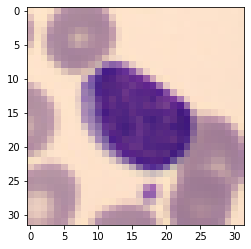

In [ ]:
plt.imshow(img_val_dataset[1706][0].permute(1,2,0))

In [ ]:
predictions.unique(return_counts=True)

(tensor([-1,  0,  1]), tensor([1057, 1315,    2]))

In [ ]:
(imgs_batch, labels_batch) = next(iter(img_val_classification_loader))

In [ ]:
outputs_batch = model_classification(imgs_batch.to(device))
outputs_batch

tensor([[ 2.5144, -0.5572],
        [ 2.2145, -0.1630],
        [ 3.6727, -1.5586],
        [ 1.0405, -0.0661],
        [ 2.3056, -0.1760],
        [ 3.0803, -0.8553],
        [ 3.0701, -0.2677],
        [ 3.3830, -0.3144],
        [ 0.3918,  2.0654],
        [ 2.9383, -0.2764]], device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
image_features

tensor([[-2.6745e+00,  1.6467e+00, -3.2823e-01,  1.5388e+01, -1.6697e-02,
         -1.9276e+00, -3.8355e+00, -3.2458e+00, -5.0571e-01, -1.4163e+00],
        [-7.8509e-01, -1.9101e+00, -2.0625e-01,  1.5143e+01,  1.1333e-01,
         -2.0850e+00, -2.1098e+00, -1.9906e+00, -4.2100e-01, -7.5462e-01],
        [-4.8618e+00,  5.8649e+00, -6.7394e-01,  1.8559e+01, -2.2071e-01,
         -1.8535e+00, -6.5100e+00, -5.5706e+00, -1.0529e+00, -2.2049e+00],
        [-1.0009e+00,  1.8263e-01, -1.9646e-01,  6.4282e+00,  7.9963e-03,
         -7.6740e-01, -9.2587e-01, -1.0461e+00, -1.3969e-01, -5.7626e-01],
        [-2.2472e-01, -2.3929e+00, -1.7622e-01,  1.5821e+01,  1.1237e-01,
         -2.3041e+00, -2.2370e+00, -2.0411e+00, -4.7098e-01, -8.1026e-01],
        [-3.6264e+00,  2.7616e+00, -4.4874e-01,  1.8127e+01, -5.9127e-02,
         -2.0471e+00, -4.9895e+00, -4.2259e+00, -7.2773e-01, -1.6329e+00],
        [-6.9057e-01, -2.9749e+00, -2.3280e-01,  2.1380e+01,  1.5157e-01,
         -3.0737e+00, -3.1185e+0

In [ ]:
(outputs_batch[:,0] - outputs_batch[:,1]).abs()

tensor([4.1507, 2.5025, 3.4444, 3.5809, 3.2955, 3.3554, 2.0405, 3.1907, 2.6242,
        4.1436], device='cuda:0', grad_fn=<AbsBackward>)

In [ ]:
F.softmax(outputs_batch)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor([[0.3937, 0.6063],
        [0.0679, 0.9321],
        [0.4778, 0.5222],
        [0.3235, 0.6765],
        [0.1877, 0.8123],
        [0.2809, 0.7191],
        [0.0398, 0.9602],
        [0.2103, 0.7897],
        [0.1131, 0.8869],
        [0.3387, 0.6613]], device='cuda:0', grad_fn=<SoftmaxBackward>)

# Final model with selection of most meaningful images

Now that we have a model that is trained to predict 0 or 1 for a single image, we will use the images that the model is most certain about in order to do the final prediction.

In [ ]:
image_features = None
    
def extract_image_features(model, input, output, *args):
    global image_features
    image_features = output

# model_classification.fc[0].register_forward_hook(extract_image_features)

In [ ]:
class MeaningfulDataset(Dataset):
    def __init__(self, lymphocytosis_dataset, single_image_model, feature_layer, meaningful_nb = 10):
        self.lymphocytosis_dataset = lymphocytosis_dataset
        self.single_image_model = single_image_model
        feature_layer.register_forward_hook(extract_image_features)
        self.meaningful_nb = meaningful_nb
    
    def __len__(self):
        return len(self.lymphocytosis_dataset)
    
    def __getitem__(self, index):
        global image_features
        annotation, bag, label = self.lymphocytosis_dataset[index]
        bag_output = self.single_image_model(bag.to(device))
        bag_confidence = (bag_output[:,0] - bag_output[:,1]).abs()
        most_meaningful_indices = bag_confidence.argsort()[:self.meaningful_nb]
        most_meaningful_images = bag[most_meaningful_indices]
        self.single_image_model(most_meaningful_images.to(device))
        return annotation, image_features.flatten(), label

In [ ]:
meaningful_train = MeaningfulDataset(lymphocytosis_train_dataset, model_classification, model_classification.fc[0])
meaningful_val = MeaningfulDataset(lymphocytosis_val_dataset, model_classification, model_classification.fc[0])
meaningful_test = MeaningfulDataset(lymphocytosis_test_dataset, model_classification, model_classification.fc[0])

In [ ]:
def construct_dataframe(dataset):
    records = {
        "GENDER": [],
        "LYMPH_COUNT": [],
        "AGE": [],
        "IMAGE_FEATURES": [],
        "LABEL": [],
    }
    for annotation, image_features, label in tqdm(dataset):
        records["GENDER"].append(annotation["GENDER"])
        records["LYMPH_COUNT"].append(annotation["LYMPH_COUNT"])
        records["AGE"].append(annotation["AGE"])
        records["IMAGE_FEATURES"].append(list(image_features.cpu().data.numpy()))
        records["LABEL"].append(label[0])

    df = pd.DataFrame(records)
    df_image_features = df["IMAGE_FEATURES"].apply(pd.Series)
    final_df = pd.concat((df, df_image_features), axis=1).drop(columns=["IMAGE_FEATURES"])
    return final_df

In [ ]:
meaningful_train_df = construct_dataframe(meaningful_train)
meaningful_val_df = construct_dataframe(meaningful_val)
meaningful_test_df = construct_dataframe(meaningful_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
meaningful_test_df.head()

,GENDER,LYMPH_COUNT,AGE,LABEL,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,1,5.76,74.956879,-1,-3.232631,4.114411,-3.860815,-2.356632,-2.934089,-3.222044,-2.189068,4.177739,-2.707197,-3.386699,-2.006725,1.562009,-1.081323,-1.799070,-1.510441,-2.136618,-2.466699,2.098050,-2.392680,-2.730819,-2.983002,3.655742,-2.805019,-2.440731,-2.545987,-2.973707,-2.538907,3.263342,-3.113074,-3.791679,-2.067842,0.743334,-0.710997,-1.512123,-1.682614,-1.748492,...,-2.586806,2.686081,-1.549539,-1.053950,-1.125497,-1.816653,-1.201109,-1.981995,-2.063338,-2.112481,-3.831050,3.348287,-2.608629,-0.903755,-1.784016,-2.405854,-1.794742,0.567840,-1.673221,-3.434178,-2.768231,4.457490,-3.820585,-1.767571,-2.053886,-2.705962,-1.552582,1.208726,-1.762633,-3.091961,-3.485917,0.853322,-1.025897,-1.508633,-2.020400,-2.077531,-2.432327,4.868421,-1.904334,-3.478836
1,1,32.00,80.826831,-1,-3.525661,3.714803,-3.531494,-2.165663,-3.039987,-3.024284,-1.868529,3.798290,-2.937754,-2.813152,-3.953956,4.508595,-4.570174,-2.355254,-3.367125,-3.396039,-1.984760,4.372525,-2.863848,-3.040245,-1.991676,0.245843,-0.243219,-1.210678,-1.702205,-1.590280,-1.621385,1.176487,-2.305520,-2.279366,-3.470066,5.120324,-3.910287,-3.227689,-2.905571,-4.293458,...,-2.354358,0.643722,-1.060626,-1.377985,-2.247980,-1.840706,-1.792261,2.863398,-2.548880,-2.322339,-2.724779,0.962255,-1.435092,-1.817255,-2.387449,-2.202669,-1.998265,3.503217,-2.491567,-2.643270,-2.143207,-0.284461,-0.262549,-1.320047,-1.717284,-1.574432,-1.851333,2.640880,-2.069928,-2.375093,-2.812042,0.911717,-0.997550,-1.542066,-2.166903,-2.054044,-1.945664,3.657171,-2.227572,-2.887173
2,1,4.60,91.545517,-1,-2.937934,2.144656,-1.339232,-0.863432,-1.103598,-1.550370,-1.830397,0.784017,-1.182186,-3.664097,-2.557308,4.070535,-3.551316,-2.951570,-2.528091,-3.472911,-3.290594,6.074640,-2.522179,-4.045610,-2.673816,4.186048,-3.065244,-2.968570,-2.481261,-3.321003,-3.195766,6.242742,-2.385868,-4.190970,-2.575352,3.940217,-3.266032,-3.005141,-2.327575,-3.334145,...,-2.001638,-0.054919,0.789784,-1.546631,-1.133510,-1.233156,-2.419358,2.728128,-1.588741,-3.436379,-3.182018,5.789171,-4.394749,-1.937414,-1.799223,-2.680915,-1.647505,0.318212,-1.586832,-3.894970,-3.579996,6.064533,-4.510181,-1.714139,-2.000965,-2.619407,-1.380432,-1.318293,-2.073692,-3.395939,-3.028991,0.001447,0.095777,-2.122582,-1.677385,-2.068027,-3.287885,6.927974,-1.635494,-4.498977
3,1,4.80,87.162218,-1,-2.616888,3.097125,-1.495980,-2.829439,-2.465364,-3.020682,-3.165240,4.547961,-3.294095,-3.954406,-2.253884,3.338599,-2.371067,-2.487301,-1.995899,-2.858193,-2.827733,5.007930,-2.161743,-4.057601,-2.182013,1.597494,-1.688770,-1.976890,-1.513183,-2.049772,-2.697564,5.626810,-1.595891,-3.594294,-2.118534,1.035241,0.490678,-2.220688,-1.637149,-1.780527,...,-3.334466,5.668121,-4.777593,-1.700177,-2.560461,-3.167016,-1.500068,-0.520486,-2.735982,-2.716107,-4.210909,6.250349,-4.879077,-1.726178,-1.987525,-2.645079,-1.863788,-0.118458,-1.487932,-4.698980,-3.584163,6.596484,-4.477069,-2.137858,-2.441718,-3.439755,-1.593931,-1.290471,-2.939631,-3.203552,-3.691075,6.835616,-4.907052,-1.913713,-2.315335,-3.152487,-1.138382,-1.705285,-2.579690,-3.122314
4,0,6.24,50.636550,-1,-2.754067,1.100739,-0.614923,-1.204453,-1.170780,-1.589527,-1.999548,2.258194,-1.419234,-3.525982,-2.808070,1.099291,-0.935680,-1.046560,-1.507567,-1.689013,-2.006012,2.762761,-1.424786,-3.317911,-3.411388,2.913533,-2.390123,-1.028838,-1.634439,-2.077434,-1.766137,1.197723,-1.437972,-3.459475,-3.462095,1.615927,-1.204637,-1.273986,-1.431695,-2.037260,...,-3.148332,2.657386,-1.564679,-0.872827,-1.454772,-1.811619,-1.549355,-0.378869,-1.705155,-3.090938,-2.692792,-0.388247,0.121517,-1.109154,-1.727507,-1.668606,-2.191324,3.931437,-1.727514,-3.024975,-3.958685,3.939514,-2.443916,-0.900615,-1.144507,-2.005023,-1.542297,-1.020277,-1.

In [ ]:
from xgboost import XGBClassifier

In [ ]:
X_train, y_train = meaningful_train_df.drop(columns=["LABEL"]), meaningful_train_df["LABEL"]
X_val, y_val = meaningful_val_df.drop(columns=["LABEL"]), meaningful_val_df["LABEL"]
X_test, y_test = meaningful_test_df.drop(columns=["LABEL"]), meaningful_test_df["LABEL"]
clf = XGBClassifier()
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
y_train_pred = clf.predict(X_train)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00        97

    accuracy                           1.00       130
   macro avg       1.00      1.00      1.00       130
weighted avg       1.00      1.00      1.00       130



In [ ]:
y_val_pred = clf.predict(X_val)
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.72      0.76      0.74        17
           1       0.73      0.69      0.71        16

    accuracy                           0.73        33
   macro avg       0.73      0.73      0.73        33
weighted avg       0.73      0.73      0.73        33



In [ ]:
test_ids = lymphocytosis_test_dataset.test_ids

In [ ]:
y_test_pred = clf.predict(X_test)

In [ ]:
results_test_df = pd.DataFrame({"Id":test_ids, "Predicted":y_test_pred})
results_test_df.head()

,Id,Predicted
0,P71,1
1,P16,1
2,P114,1
3,P170,1
4,P98,0


In [ ]:
results_test_df.to_csv("submission.csv", index=False)